In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [2]:
df =  pd.read_csv("data.csv")
df.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka


In [3]:
df = df.sample(frac=1).reset_index(drop = True)
df.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_05_kna
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_03_ga
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_06_cha
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_04_gha
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_04_gha


In [4]:
df.shape

(92000, 1025)

In [5]:
train_df = df[0:80000].copy()
test_df = df[80000:].copy()
train_df.shape,test_df.shape

((80000, 1025), (12000, 1025))

In [6]:
label = train_df['character'].values
y_train = np.zeros([train_df.shape[0],df['character'].unique().shape[0]])

In [7]:
from sklearn.preprocessing import LabelBinarizer
binencoder = LabelBinarizer()
y_train = binencoder.fit_transform(label)

In [8]:
train_df= train_df.drop(['character'],axis=1)
X_train = train_df.to_numpy()
X_train = np.reshape(X_train,(X_train.shape[0],32,32,1))

In [9]:
X_train.shape

(80000, 32, 32, 1)

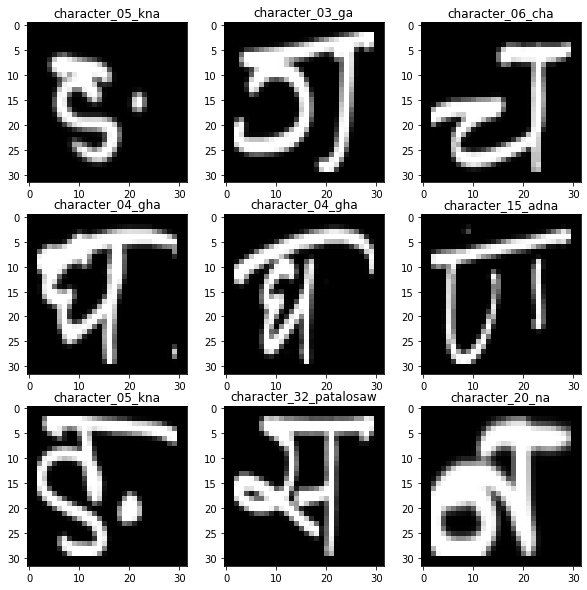

In [10]:
plt.figure(figsize=(10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.title(str(label[i]))
    plt.imshow(X_train[i].reshape((32,32)),cmap='gray')
# show the plot
plt.show()

In [11]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

Using TensorFlow backend.


In [12]:
input_shape = 32,32,1
num_classes = 46

In [13]:
def googlenet(input_shape, n_classes):
    
    def inception_block(x, f):
        t1 = Conv2D(f[0], 1, activation='relu')(x)
        
        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
        
        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)
        
        t4 = MaxPool2D(3, 1, padding='same')(x)
        t4 = Conv2D(f[5], 1, activation='relu')(t4)
        output = Concatenate()([t1, t2, t3, t4])
        return output
    
    input = Input(input_shape)
    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
  
    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = MaxPool2D(3, strides=2, padding='same')(x)
  
    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [160, 112, 224, 24, 64, 64])
    x = inception_block(x, [128, 128, 256, 24, 64, 64])
    x = inception_block(x, [112, 144, 288, 32, 64, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = inception_block(x, [384, 192, 384, 48, 128, 128])
  
    #x = AvgPool2D(7, strides=1)(x)
    #x = Dropout(0.4)(x)
    x=GlobalAvgPool2D()(x)
    x=Dropout(0.4)(x)
  
    #x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)
  
    model = Model(input, output)
    return model

In [14]:
model = googlenet(input_shape,num_classes)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     4160        max_pooling2d_1[0][0]            
__________

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])
hist = model.fit(X_train,y_train,batch_size=14,epochs=6, verbose=1, validation_split= 0.15)


Train on 68000 samples, validate on 12000 samples
Epoch 1/6
68000/68000 [==============================] - 786s 12ms/step - loss: 3.8339 - accuracy: 0.0216 - val_loss: 3.8302 - val_accuracy: 0.0197
Epoch 2/6
68000/68000 [==============================] - 786s 12ms/step - loss: 3.8297 - accuracy: 0.0214 - val_loss: 3.8298 - val_accuracy: 0.0210
Epoch 3/6
68000/68000 [==============================] - 781s 11ms/step - loss: 3.8297 - accuracy: 0.0211 - val_loss: 3.8297 - val_accuracy: 0.0207
Epoch 4/6
68000/68000 [==============================] - 777s 11ms/step - loss: 3.8298 - accuracy: 0.0210 - val_loss: 3.8296 - val_accuracy: 0.0214
Epoch 5/6
68000/68000 [==============================] - 780s 11ms/step - loss: 3.8297 - accuracy: 0.0203 - val_loss: 3.8295 - val_accuracy: 0.0216
Epoch 6/6
68000/68000 [==============================] - 786s 12ms/step - loss: 3.8297 - accuracy: 0.0214 - val_loss: 3.8294 - val_accuracy: 0.0195


In [30]:
%matplotlib inline

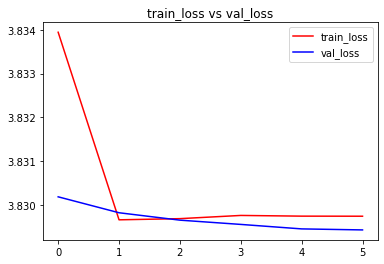

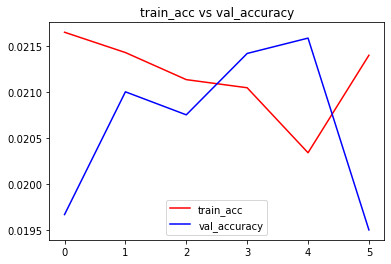

<Figure size 432x288 with 0 Axes>

In [33]:
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_accuracy')
plt.title('train_acc vs val_accuracy')
plt.legend()
plt.figure()

model.save('my_model.h5')

In [57]:
label_test = test_df['character'].values
y_test = np.zeros([train_df.shape[0],df['character'].unique().shape[0]])
binencoder = LabelBinarizer()
y_test = binencoder.fit_transform(label_test)
test_df = test_df.drop(['character'],axis=1)
X_test = test_df.to_numpy()
X_test = np.reshape(X_test,(X_test.shape[0],32,32,1))
model.evaluate(X_test, y_test)

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Riddhi Pawar\Anacondaa\envs\PythonCPU\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Riddhi Pawar\Anacondaa\envs\PythonCPU\lib\asyncio\selector_events.py", line 125, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Riddhi Pawar\Anacondaa\envs\PythonCPU\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Riddhi Pawar\Anacondaa\envs\PythonCPU\lib\asyncio\selector_events.py", line 125, in _read_from_self
    data = self._ssock.recv(4

KeyError: 'character'

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Riddhi Pawar\Anacondaa\envs\PythonCPU\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Riddhi Pawar\Anacondaa\envs\PythonCPU\lib\asyncio\selector_events.py", line 125, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Riddhi Pawar\Anacondaa\envs\PythonCPU\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Riddhi Pawar\Anacondaa\envs\PythonCPU\lib\asyncio\selector_events.py", line 125, in _read_from_self
    data = self._ssock.recv(4